## Recognition of texts in editions of the Cyrillic Church Slavonic font

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from heapq import *
import tensorflow as tf
from tensorflow import keras
from alphabet import CHURCH_SLAVONIC_LETTERS, CHURCH_SLAVONIC_DIACRITICS, CHURCH_SLAVONIC_VOWELS, LETTERS_WITH_TITLE
from keras import backend as K
K.set_image_data_format('channels_first')

### Text line segmentation

Detection of peaks in the horizontal projection of the image. These peaks give us an idea of where the segmentation between two lines can be done.

In [23]:
def get_peak_regions(hpp):
    divider=1.8
    threshold = (np.max(hpp)-np.min(hpp))/divider
    threshold_line = [threshold for i in range(len(hpp))]
    plt.figure(1)
    plt.plot(hpp)
    plt.plot(threshold_line)
    plt.show()
    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

def get_walking_regions_between_lines(peaks):
    hpp_clusters = []
    cluster = []
    for index, value in enumerate(peaks):
        cluster.append(value)
        if index < len(peaks)-1 and peaks[index+1] - value > 1:
            hpp_clusters.append(cluster)
            cluster = []
        if index == len(peaks)-1:
            hpp_clusters.append(cluster)
            cluster = []
    return hpp_clusters

A* Path planning algorithm along the segmentation region.

In [3]:
def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []
    heappush(oheap, (fscore[start], start))
    while oheap:
        current = heappop(oheap)[1]
        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data
        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    continue
            else:
                continue  
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue    
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))     
    return []

Converting to Grayscale Using the Otsu's Method.

In [4]:
def thresholding(image, inv=True):
    if inv:
        ret, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        ret, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)
    return thresh

Definition of regions where upper line text is connected to the lower line.

In [5]:
def existence_of_path(window_image):
    if 0 in np.sum(window_image, axis=1):
        return True
    padded_window = np.zeros((window_image.shape[0],1))
    world_map = np.hstack((padded_window, np.hstack((window_image,padded_window)) ) )
    path = np.array(astar(world_map, (int(world_map.shape[0]/2), 0), (int(world_map.shape[0]/2), world_map.shape[1])))
    if len(path) > 0:
        return True
    return False

def get_road_block_regions(nmap):
    road_blocks = []
    needtobreak = False
    for col in range(nmap.shape[1]):
        start = col
        end = col+20
        if end > nmap.shape[1]-1:
            end = nmap.shape[1]-1
            needtobreak = True
        if existence_of_path(nmap[:, start:end]) == False:
            road_blocks.append(col)
        if needtobreak == True:
            break
    return road_blocks

def merge_road_blocks(road_blocks):
    blocks_cluster_groups = []
    blocks_cluster = []
    size = len(road_blocks)
    for index, value in enumerate(road_blocks):
        blocks_cluster.append(value)
        if index < size-1 and (road_blocks[index+1] - road_blocks[index]) > 1:
            blocks_cluster_groups.append([blocks_cluster[0], blocks_cluster[len(blocks_cluster)-1]])
            blocks_cluster = []
        if index == size-1 and len(blocks_cluster) > 0:
            blocks_cluster_groups.append([blocks_cluster[0], blocks_cluster[len(blocks_cluster)-1]])
            blocks_cluster = []
    return blocks_cluster_groups

Extracting a line from an image

In [6]:
def cut_line_from_image(image, lower_line, upper_line):
    lower_boundary = np.min(lower_line[:, 0])
    upper_boundary = np.max(upper_line[:, 0])
    image_copy = np.copy(image)
    r, c = image_copy.shape
    for index in range(c-1):
        image_copy[0:lower_line[index, 0], index] = 255
        image_copy[upper_line[index, 0]:r, index] = 255
    return image_copy[lower_boundary:upper_boundary, :]

def split_indexes_into_groups(peaks):
    len_peaks = [[peaks[0]]]
    for i in range (1, len(peaks)):
        if peaks[i] == peaks[i-1] + 1:
            len_peaks[len(len_peaks)-1].append(peaks[i])
        else:
            len_peaks.append([peaks[i]])
    return len_peaks

This function detects short lines that were skipped when peaks were detected in the horizontal projection. Since the width of the lines in old printed books is the same, it's possible to find missing short lines that are the same width as those found earlier.

In [26]:
def add_short_lines(peaks_index, hpp):
    hpp_peaks = split_indexes_into_groups(peaks_index)
    avg_len = sum([len(x) for x in hpp_peaks])/len(hpp_peaks)
    for i in range(len(hpp_peaks)):
        if len(hpp_peaks[i]) <= avg_len/2:
            left_hpp = hpp_peaks[i-1][-1] if i != 0 else -1000
            right_hpp = hpp_peaks[i+1][0] if i != len(hpp_peaks)-1 else 1000
            if (hpp_peaks[i][0] - left_hpp) < (right_hpp - hpp_peaks[i][-1]):
                for j in range(left_hpp+1, hpp_peaks[i][0]):
                    peaks_index = np.append(j, peaks_index)
            else:
                 for j in range(hpp_peaks[i][-1]+1, right_hpp):
                    peaks_index = np.append(j, peaks_index)
    peaks_index.sort()
    divider=1.8
    threshold = (np.max(hpp)-np.min(hpp))/divider
    inv_peaks_index = []
    for i in range(len(hpp)):
        if i not in peaks_index:
            inv_peaks_index.append(i)
    inv_hpp_peaks = split_indexes_into_groups(inv_peaks_index)
    length = [len(x) for x in inv_hpp_peaks]
    max_len = max(length)
    min_len = max(length) if min(length) <= max(length)/2 else min(length)
    
    min_threshold = np.min(hpp) + 1000
    h = (threshold - min_threshold)/10
    new_peaks = []
    while min_threshold < threshold:
        peaks = []
        for i, hppv in enumerate(hpp):
            if hppv > min_threshold:
                peaks.append(i)
        len_peaks = split_indexes_into_groups(peaks)
        peaks = []
        for lenp in len_peaks:
            if min_len <= len(lenp) <= max_len:
                for l in lenp:
                    peaks.append(l)
        peaks = [x for x in peaks if x not in inv_peaks_index]
        if len(peaks):
            len_peaks = split_indexes_into_groups(peaks)
            for lenp in len_peaks:
                if min_len <= len(lenp) <= max_len:
                    for l in lenp:
                        if l not in new_peaks:
                            new_peaks.append(l)
        min_threshold += h
    for npeak in new_peaks:
        peaks_index = peaks_index[peaks_index != npeak]
    return peaks_index

Line segmentation function.

In [27]:
def line_segmentation(path):
    img = cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)
    Gx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    Gy = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    sobel_img = np.sqrt(Gx * Gx + Gy * Gy)
    hpp = np.sum(sobel_img, axis=1)
    peaks = get_peak_regions(hpp)
    peaks_index = np.array(peaks)[:,0].astype(int)
#     peaks_index = add_short_lines(peaks_index, hpp)

    segmented_img = np.copy(img)
    h, w = segmented_img.shape
    for i in range(h):
        if i in peaks_index:
            segmented_img[i, :] = 0
    hpp_clusters = get_walking_regions_between_lines(peaks_index)
    binary_image = thresholding(img)
    
    for cluster_of_interest in hpp_clusters:
        nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
        road_blocks = get_road_block_regions(nmap)
        road_blocks_cluster_groups = merge_road_blocks(road_blocks)
        val = 10
        for index, road_blocks in enumerate(road_blocks_cluster_groups):
            window_image = nmap[:, road_blocks[0]: road_blocks[1]+val]
            window_image *= 0
            binary_image[cluster_of_interest[0]:cluster_of_interest[-1],:][:, road_blocks[0]: road_blocks[1]+val] = window_image
    
    line_segments = []
    for i, cluster_of_interest in enumerate(hpp_clusters):
        nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
        path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
        if len(path) > 0:
            offset_from_top = cluster_of_interest[0]
            path[:,0] += offset_from_top
            line_segments.append(path)
    
    cluster_of_interest = hpp_clusters[1]
    offset_from_top = cluster_of_interest[0]
    fig, ax = plt.subplots(figsize=(20,10), ncols=2)
    for path in line_segments:
        ax[1].plot((path[:,1]), path[:,0])
    ax[1].axis("off")
    ax[0].axis("off")
    ax[1].imshow(img, cmap="gray")
    ax[0].imshow(img, cmap="gray")
    
    last_bottom_row = np.flip(np.column_stack(((np.ones((img.shape[1],))*img.shape[0]), 
                                               np.arange(img.shape[1]))).astype(int), axis=0)
    line_segments.append(last_bottom_row)   
    
    line_images = []
    line_count = len(line_segments)
    
    for line_index in range(line_count-1):
        line_image = cut_line_from_image(img, line_segments[line_index], line_segments[line_index+1])
        line_images.append(line_image)
        
    sum = 0
    for line_index in range(line_count-1):
        sum += np.min(line_segments[line_index+1][:, 0]) - np.min(line_segments[line_index][:, 0])
    avg = sum / line_count

    for line_index in range(line_count-1):
        line_width = np.min(line_segments[line_index+1][:, 0]) - np.min(line_segments[line_index][:, 0])
        if line_width < avg // 2 and line_index == line_count-2:
            line_images.pop(line_index)
    return line_images

### Word segmentation

Removing white space to the left and right of a line.

In [9]:
def cropp_line(line_image):
    thresh = thresholding(line_image)
    binary = line_image > thresh
    vertical_projection = np.sum(binary, axis=0)
    height = line_image.shape[0]
    index = 0       
    while vertical_projection[index] == height:
        index += 1
    if index > 2:
        index -= 2
    line_image = line_image[:, index:]
    
    thresh = thresholding(line_image)
    binary = line_image > thresh
    vertical_projection = np.sum(binary, axis=0)
    
    index = line_image.shape[1] - 1
    while vertical_projection[index] == height:
        index -= 1
    if index < line_image.shape[1] - 1:
        index += 2
    
    line_image = line_image[:, :index]
    return line_image

Binarization and noise removal from a line image. Then finding the vertical projection of the image to find long white blocks because thats what represents spaces.

In [10]:
def word_segmentation(line_image):
    line = cropp_line(line_image)
    dst = cv2.fastNlMeansDenoising(line, None, 12, 7, 21)
    thresh = thresholding(dst)
    kernel = np.ones((1, 1), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations = 1) 
    binary = line > dilated
    vertical_projection = np.sum(binary, axis=0)
    
    height = line.shape[0]
    whitespace_lengths = []
    whitespace = 0
    for index, vp in enumerate(vertical_projection):
        if vp == height:
            whitespace = whitespace + 1
        elif vp != height:
            if whitespace != 0:
                whitespace_lengths.append(whitespace)
            whitespace = 0
        if index == len(vertical_projection) - 1 and vp == height:
            if whitespace != 0:
                whitespace_lengths.append(whitespace)

    while 1 in whitespace_lengths:
        whitespace_lengths.remove(1)       

    avg_white_space_length = np.mean(whitespace_lengths)
    
    whitespace_length = 0
    divider_indexes = []
    divider_indexes.append(int(0))
    for index, vp in enumerate(vertical_projection):
        if vp == height:
            whitespace_length = whitespace_length + 1

        elif vp != height:
            if whitespace_length != 0 and whitespace_length > avg_white_space_length:
                divider_indexes.append(int(index-2))
            whitespace_length = 0

        if index == len(vertical_projection)-1:
            divider_indexes.append(int(index))
            whitespace_length = 0

    line_copy = line.copy()
    for i in range(line_copy.shape[0]):
        for j in range(line_copy.shape[1]):
            if j in divider_indexes and j != 0 and j != line_copy.shape[1] - 1:
                line_copy[i][j] = 0
    
    plt.figure(figsize=(6,15))
    plt.imshow(line_copy, cmap="gray")
    plt.show()
    
    divider_indexes = np.array(divider_indexes)
    dividers = np.column_stack((divider_indexes[:-1],divider_indexes[1:]))
    
    words = []
    for index, window in enumerate(dividers):
        words.append(line[:,window[0]:window[1]])

    return words

In [11]:
def hconcat_resize_min(im_list):
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=cv2.INTER_CUBIC)
                      for im in im_list]
    print('*', im_list_resize[0].shape, im_list_resize[1].shape)
    return cv2.hconcat(im_list_resize)

def min_sorted_contours(sorted_contours):
    min_y = 100
    for ctr in sorted_contours:
        x, y, w, h = cv2.boundingRect(ctr)
        if y < min_y:
            min_y = y
    return min_y

def find_contours(letter, sort):
    (contours, heirarchy) = cv2.findContours(letter.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[sort])
    return sorted_contours

### Letter segmentation

The function that connects a cut character that has an accent above it

In [12]:
def merge_letters(letters):
    i = 0
    unite_letters = []
    while i < len(letters):
        sorted_contours = find_contours(letters[i], 1) 
        if len(sorted_contours) >= 2 and i != len(letters)-1:
            x1, y1, w1, h1 = cv2.boundingRect(sorted_contours[0])
            y2 = min_sorted_contours(sorted_contours[1:])
            if y2 > y1+h1 and y1+h1 < letters[i].shape[0]//2 and x1+w1 == letters[i].shape[1] and ((x1+w1)-x1)*((y1+h1)-y1)>10:
                sorted_contours1 = find_contours(letters[i+1], 1)
                if len(sorted_contours1) >= 2:
                    x3, y3, w3, h3 = cv2.boundingRect(sorted_contours1[0])
                    y4 = min_sorted_contours(sorted_contours1[1:])
                    if y4 > y3+h3 and y3+h3 < letters[i].shape[0]//2 and x3 == 0 and ((x3+w3)-x3)*((y3+h3)-y3) > 10: 
                        a = hconcat_resize_min([letters[i], letters[i+1]])
                        unite_letters.append(a)
                        i += 2
                        continue
        unite_letters.append(letters[i])
        i += 1
    return unite_letters

Segmentation of letters in a word image using ```find contours``` from OpenCV.

In [13]:
def letter_segmentation(word):
    dst = cv2.fastNlMeansDenoising(word,None, 12, 7, 21)
    thresh_img = thresholding(dst)

    kernel = np.ones((2, 1), np.uint8)
    dilated = cv2.dilate(thresh_img, kernel, iterations = 1)    
    sorted_contours = find_contours(dilated, 0)
    divider_indexes = []
    
    word_copy = word.copy()
    top = word_copy.shape[0] / 2
    bottom = word_copy.shape[0] / 3 * 2

    letters = []
    for ctr in sorted_contours:
        x,y,w,h = cv2.boundingRect(ctr)
        cv2.rectangle(word_copy, (x,y), (x+w, y+h), (40, 100, 250), 1) 
        if y+h > top+3 and y-1 < bottom:
            if ((x+w)-x) * ((y+h)-y) >= 10:   
                if x != 0:
                    letter = thresh_img[:y+h+1, x-1:x+w+1]
                    divider_indexes.append(x-1)
                else: 
                    letter = thresh_img[:y+h+1, x:x+w+1]
                    divider_indexes.append(x)
                letters.append(letter)
                
#     word_copy2 = word.copy()
#     for i in range(word_copy2.shape[0]):
#         for j in range(word_copy2.shape[1]):
#             if j in divider_indexes and j != 1 and j != word_copy2.shape[1] - 1:
#                 word_copy2[i][j] = 0
    
#     fig, ax = plt.subplots(nrows=2, figsize=(5,5))
#     ax[0].imshow(word_copy, cmap="gray")
#     ax[1].imshow(word_copy2, cmap="gray")
    
    return merge_letters(letters)

Two or more letters that have been combined into one contour are additionally cut if the image width is 2 times larger than the average letter.

In [14]:
def find_height_of_letter(letter):
    thresh_letter = thresholding(letter, False)
    i = 0
    f = True
    while f and i < thresh_letter.shape[0]:
        if np.count_nonzero(thresh_letter[i] == 255) != 0:
            f = False
        else:
            i += 1
    return thresh_letter.shape[0] - i

def cut_double_letters(array_lines):
    suma_len = 0
    suma_height = 0
    count = 0
    for i in range(len(array_lines)):
        for j in range(len(array_lines[i])):
            for k in range(len(array_lines[i][j])):
                letter = array_lines[i][j][k]
                suma_height += find_height_of_letter(letter)
                suma_len += letter.shape[1]
                count += 1
    avg_len = suma_len / count
    avg_height = suma_height / count
    
    new_array = []
    for i in range(len(array_lines)):
        array_words = []
        for j in range(len(array_lines[i])):
            array_letters = []
            for k in range(len(array_lines[i][j])):
                letter = array_lines[i][j][k]
                height = find_height_of_letter(letter)
                width = letter.shape[1]
                if width > avg_len * 2 and height < avg_height:
                    amt = round(width / avg_len)
                    for s in range(0, amt):
                        if int(s*width/amt) != 0:
                            array_letters.append(letter[:, int(s*width/amt)-1:int((s+1)*width/amt)+1])
                        else:
                            array_letters.append(letter[:, int(s*width/amt):int((s+1)*width/amt)+1])
                else:
                    array_letters.append(letter)
            array_words.append(array_letters)
        new_array.append(array_words)
    return new_array

### Letter recognition

Images with letters are reduced to size (28, 28), images with superscripts are reduced to size (16, 16).

In [15]:
def resize_image(letter, size=(28, 28)):
    h, w = letter.shape
    if h != w:
        if w > h:
            add_top = (w-h) // 2 if (w-h)%2 == 0 else (w-h) // 2 + 1
            add_bottom = (w-h) // 2
            array = [0 for x in range(w)]
            ndarray = np.array(array, dtype=int)
            for _ in range(add_top):
                letter = np.vstack((ndarray, letter))
            for _ in range(add_bottom):
                letter = np.vstack((letter, ndarray))
        else:
            add_left = (h-w) // 2 if (h-w)%2 == 0 else (h-w) // 2 + 1
            add_right = (h-w) // 2
            nd = np.array([0])
            for _ in range(h-1):
                nd = np.vstack((nd, [0]))
            for _ in range(add_left):
                letter = np.insert(letter, 0, [0], axis = 1)
            for _ in range(add_right):
                letter = np.append(letter, nd, axis = 1)
    return cv2.resize(letter.astype(float), size)

def remove_small_contours(sorted_contours):
    new_contours = []
    for i in range(len(sorted_contours)):
        x,y,w,h = cv2.boundingRect(sorted_contours[i])
        if ((x+w)-x) * ((y+h)-y) > 3:
            new_contours.append(sorted_contours[i])
    return new_contours

def cropp_letter(letter, a, b, c, d):
    if c != 0:
        return letter[a-1:b+1, c-1:d+1] if a != 0 else letter[a:b+1, c-1:d+1]
    else: 
        return letter[a-1:b+1, c:d+1] if a != 0 else letter[a:b+1, c:d+1]

This function finds a letter and its accent in an image.

In [16]:
def find_parts_of_letters(sorted_contours, letter):
    parts_of_letters = []
    if len(sorted_contours) == 1:
        x,y,w,h = cv2.boundingRect(sorted_contours[0])
        cut_letter = letter[y-1:, :] if y != 0 else letter
        parts_of_letters.append(cut_letter)
    else:
        if len(sorted_contours) == 2:
            x1, y1, w1, h1 = cv2.boundingRect(sorted_contours[0])
            x2, y2, w2, h2 = cv2.boundingRect(sorted_contours[1])
            if y2 >= y1+h1 and y1+h1 < letter.shape[0]//2:
                if (x1 <= letter.shape[1] // 2 - 2 <= x1+w1) or (x1 <= letter.shape[1] // 2 + 2 <= x1+w1):
                    cut_letter1 = letter[y2-1:, :]
                    parts_of_letters.append(cut_letter1)
                    cut_letter2 = cropp_letter(letter, y1, y1+h1, x1, x1+w1)
                    parts_of_letters.append(cut_letter2)
                else:
                    cut_letter = letter[y2-1:, :]
                    parts_of_letters.append(cut_letter)
            else:
                y = min_sorted_contours(sorted_contours)
                cut_letter = letter[y-1:, :]
                parts_of_letters.append(cut_letter)
        else:
            x1, y1, w1, h1 = cv2.boundingRect(sorted_contours[0])
            x2, y2, w2, h2 = cv2.boundingRect(sorted_contours[1])
            x3, y3, w3, h3 = cv2.boundingRect(sorted_contours[2])
            if y3 >= y1+h1 and y1+h1 < letter.shape[0]//2 and y3 > y2+h2 and y2+h2 < letter.shape[0]//2:
                if ((x1 <= letter.shape[1] // 2 - 2 <= x1+w1) or (x1 <= letter.shape[1] // 2 + 2 <= x1+w1)) and \
                not ((x2 <= letter.shape[1] // 2 - 2 <= x2+w2) or (x2 <= letter.shape[1] // 2 + 2 <= x2+w2)):
                    cut_letter1 = letter[y3-1:, :]
                    parts_of_letters.append(cut_letter1)
                    cut_letter2 = cropp_letter(letter, y1, y1+h1, x1, x1+w1)
                    parts_of_letters.append(cut_letter2)
                elif ((x2 <= letter.shape[1] // 2 - 2 <= x2+w2) or (x2 <= letter.shape[1] // 2 + 2 <= x2+w2)) and \
                not ((x1 <= letter.shape[1] // 2 - 2 <= x1+w1) or (x1 <= letter.shape[1] // 2 + 2 <= x1+w1)):
                    cut_letter1 = letter[y3-1:, :]
                    parts_of_letters.append(cut_letter1)
                    cut_letter2 = cropp_letter(letter, y2, y2+h2, x2, x2+w2)
                    parts_of_letters.append(cut_letter2)
                else:
                    cut_letter1 = letter[y3-1:, :]
                    parts_of_letters.append(cut_letter1)
                    cut_letter2 = cropp_letter(letter, min(y1, y2), max(y1+h1, y2+h2), min(x1, x2), max(x1+w1, x2+w2))
                    parts_of_letters.append(cut_letter2)
            else:
                y = min_sorted_contours(sorted_contours[1:])
                if y >= y1+h1 and y1+h1 < letter.shape[0]//2:
                    cut_letter1 = letter[y-1:, :]
                    parts_of_letters.append(cut_letter1)
                    cut_letter2 = cropp_letter(letter, y1, y1+h1, x1, x1+w1)
                    parts_of_letters.append(cut_letter2)
                else:
                    y = min_sorted_contours(sorted_contours)
                    cut_letter = letter[y-1:, :]
                    parts_of_letters.append(cut_letter)
    return parts_of_letters

This function recognizes letters and superscripts separately using two trained CNN.

In [17]:
def recognize_characters_from_images(array_lines):
    text = []
    new_array_lines = cut_double_letters(array_lines)
    for i in range(len(new_array_lines)):
        for j in range(len(new_array_lines[i])):
            for k in range(len(new_array_lines[i][j])):
                kernel = np.ones((1, 5), np.uint8)
                letter = new_array_lines[i][j][k]
                height = find_height_of_letter(letter)
                if letter.shape[0] - height != 0:
                    letter = letter[letter.shape[0] - height - 1:, :]
                dilated = cv2.dilate(letter, kernel, iterations = 1)    
                sorted_contours = find_contours(dilated, 1)
                sorted_contours = remove_small_contours(sorted_contours)
                if len(sorted_contours) != 0:
                    parts_of_letters = find_parts_of_letters(sorted_contours, letter)
                    parts_of_letters[0] = resize_image(parts_of_letters[0])
                    cut_letter_array = tf.keras.utils.img_to_array(parts_of_letters[0])
                    cut_letter_array /= 255
                    y_pred = model_loaded.predict(cut_letter_array)
                    y_pred_bool = (y_pred > 0.5)
                    if not (np.all(y_pred_bool == False)):
                        text.append(str(CHURCH_SLAVONIC_LETTERS[np.argmax(y_pred)]))
                    excluded = [5, 6, 8, 9]
                    if len(parts_of_letters) >= 2:
                        parts_of_letters[1] = resize_image(parts_of_letters[1], (16, 16))
                        cut_sign_array = tf.keras.utils.img_to_array(parts_of_letters[1])
                        cut_sign_array /= 255
                        y_pred = model_loaded_diac.predict(cut_sign_array)
                        y_pred_bool = (y_pred > 0.5)
                        if not (np.all(y_pred_bool == False)):
                            if np.argmax(y_pred) == 5 and text[-1] == "\u0461":
                                text.pop()
                                text.append(str(CHURCH_SLAVONIC_DIACRITICS[np.argmax(y_pred)]))
                                continue
                            if np.argmax(y_pred) == 8 and text[-1] in LETTERS_WITH_TITLE:
                                text.append(str(CHURCH_SLAVONIC_DIACRITICS[np.argmax(y_pred)]))
                                continue
                            if np.argmax(y_pred) == 3 and text[-1] == "\u0461":
                                text.append(str(CHURCH_SLAVONIC_DIACRITICS[np.argmax(y_pred)]))
                                continue
                            if np.argmax(y_pred) == 6 and text[-1] == "\u0131":
                                text.append(str(CHURCH_SLAVONIC_DIACRITICS[np.argmax(y_pred)]))
                                continue
                            if np.argmax(y_pred) == 9 and text[-1] == "\u002E":
                                text.pop()
                                text.append(':')
                                continue
                            if np.argmax(y_pred) == 9 and text[-1] == "\u002C":
                                text.pop()
                                text.append(';')
                                continue
                            if text[-1] in CHURCH_SLAVONIC_VOWELS and np.argmax(y_pred) not in excluded:
                                text.append(str(CHURCH_SLAVONIC_DIACRITICS[np.argmax(y_pred)]))

            text.append(" ")
        text.append("\n")
    return text

Removal of some recognition errors: split letters, space before colon and newline translation.

In [18]:
def connect_cut_letters(text_with_corrections, letter, next_letter=True):
    text_with_corrections.pop()
    if next_letter:
        text_with_corrections.pop()
    text_with_corrections.append(letter)

def remove_errors_from_text(text):
    text_with_corrections = [text[0], text[1]]
    cut_letter_sets = [["\u044C", "\u0131", "\u044B"], ["\u0131", "\u0131", "\u043D"], ["\u002C", "\u0131", "\u0447"],
            ["\u0446", "\u0131", "\u0449"]]
    
    for i in range(2, len(text)):
        
        if text[i] not in CHURCH_SLAVONIC_DIACRITICS:
            for cls in cut_letter_sets:
                if text[i-2] == cls[0] and text[i-1] == cls[1]:
                    connect_cut_letters(text_with_corrections, cls[2])
        
        flag = False
        if i == len(text)-1:
            for cls in cut_letter_sets:
                if text[i-1] == cls[0] and text[i] == cls[1]:
                    connect_cut_letters(text_with_corrections, cls[2], False)
                    flag = True
            if flag:
                continue
            
        if text[i-1] == "\u0131" and text[i] == "\u0440":
            text_with_corrections.pop()
            text_with_corrections.append("\u0449")
            continue
            
        if text[i-1] == " " and text[i] in [",", ":", "\n"]:
            text_with_corrections.pop()
        text_with_corrections.append(text[i])
    return text_with_corrections

Loading trained models.

In [19]:
model_loaded = keras.models.load_model('model_letters')
model_loaded_diac = keras.models.load_model('model_diac')

### Example of the algorithm

Page title: pages/ex_book2.jpg


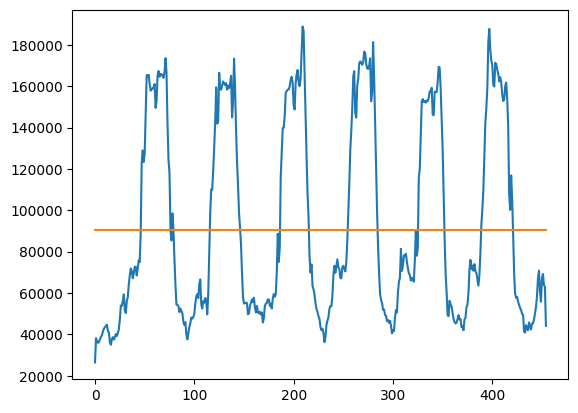

CPU times: total: 5.92 s
Wall time: 21.9 s


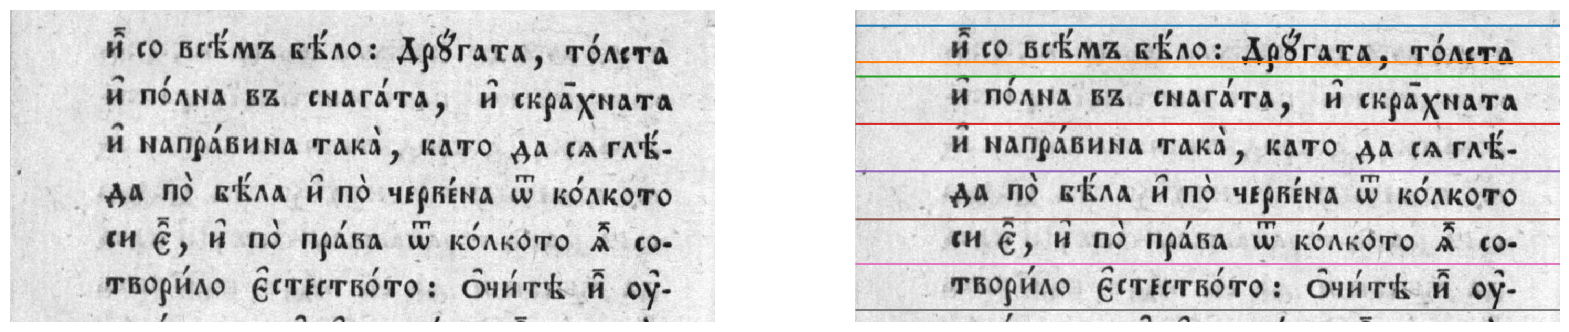

In [28]:
%%time
page = input('Page title: ')
line_images = line_segmentation(page)

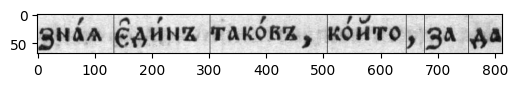

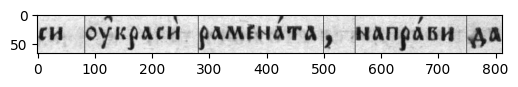

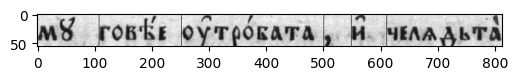

In [22]:
array_lines = []
for i in range(len(line_images)):
    array_words = []
    words = word_segmentation(line_images[i])
    for j in range(len(words)):
        array_letters = []
        letters = letter_segmentation(words[j])
        for k in range(len(letters)):
            array_letters.append(letters[k])
        array_words.append(letters)
    array_lines.append(array_words)

In [23]:
text_from_image = recognize_characters_from_images(array_lines)
text_from_image = remove_errors_from_text(text_from_image)

file = open("page.txt", "w", encoding = 'utf-8')
for char in text_from_image:
    file.write(char)
file.close()

1/1 [==============================] - 0s 29ms/step


In [24]:
for symbol in text_from_image:
    print(symbol, end = '')

зна́ѧ е҆ди́нъ тако́въ, ко́йто, за да
си оу҆красѝ рамена́та, напра́ви да
мꙋ говѣ́е оу҆тро́бата, и҆ челѧдьта̀


Image text saved to file ```page.txt```. For the correct display of characters you need to download Church Slavonic font in Unicode ([for example from this site](https://sci.ponomar.net/fonts.html)). 
The text will look like this with a special font: ![example](example.jpg)